In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import skimage as sk
from scipy import ndimage, signal, stats
from sklearn import cluster

In [2]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1, names=False):
    fnames = np.random.choice(os.listdir(images_path), k)
    images = tuple(map(get, fnames))
    if names: return images, fnames
    else: return images

def peaks_filter(x, y, peaks, k=1):
    ypeaks = y[peaks]
    xpeaks = x[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def ifft2d(image):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image)))

def freq_peaks(image):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
    Py = peaks_filter(yfreqs, ymean, ypeaks, 2)
    Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
    
    return np.abs(xfreqs[Px][0]), np.abs(xfreqs[Py][0])

def rescale(img, i, f):
    return i + (img - img.min())*(f - i)/(img.max() - img.min())

def entropy(img, r=3):
    return sk.filters.rank.entropy(
        sk.util.img_as_ubyte(rescale(img, -1, 1)), 
        sk.morphology.disk(r)
    )

def var(img, kn=(15, 15), kp=(5, 5)):
    return ndimage.minimum_filter(ndimage.uniform_filter(img**2, kn) - ndimage.uniform_filter(img, kn)**2, kp)

def vectorize(*args, **kwargs):
    def wrapper(func):
        return np.vectorize(func, **kwargs)
    return wrapper

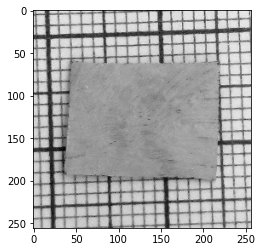

In [80]:
image = random_images()[0]
img = sk.color.rgb2gray(image)
w, h = img.shape
plt.imshow(img, cmap='gray')

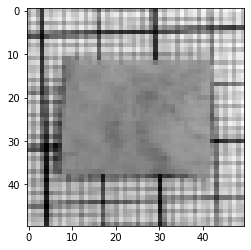

In [81]:
levels = 8
size = 50, 50

img_reduced = rescale(sk.transform.resize(img, size), 0, levels-1)
plt.imshow(img_reduced, cmap='gray')

In [82]:
def get_pieces(image, win_size):
    i_side, j_side = image.shape
    i_win, j_win = win_size
    padding = np.pad(image, (i_win//2, j_win//2), mode='reflect').astype(int)
    for i in range(0, i_side):
        for j in range(0, j_side):
            yield i, j, padding[i:i+i_win, j:j+j_win], i/i_side, j/j_side

def texture_features(image, win_size, glcm_features=(), statistical_features=()):
    out = {'i':[], 'j':[]}
    for i, j, piece, ip, jp in get_pieces(image, win_size):
        print(f'i:{ip*100:.2f}; j:{jp*100:.2f}', end='\r')
        
        if len(glcm_features):
            cocomatrix = sk.feature.graycomatrix(piece, [1], [0], levels=levels, normed=True)
            for feature_name in glcm_features:
                value = sk.feature.graycoprops(cocomatrix, prop=feature_name)[0, 0]
                try: out[feature_name].append(value)
                except KeyError: out[feature_name] = [value]
                
        if len(statistical_features):
            for feature_name in statistical_features:
                try: value = getattr(np, feature_name)(piece)
                except AttributeError: value = getattr(stats, feature_name)(piece.flat)
                finally:
                    try: out[feature_name].append(value)
                    except KeyError: out[feature_name] = [value]
                
        out['i'].append(i)
        out['j'].append(j)
    return pd.DataFrame(out)

In [83]:
%%time
texture = texture_features(img_reduced, (5, 5),
               glcm_features=('dissimilarity', 'homogeneity', 'energy'))

CPU times: total: 3.28 s
Wall time: 5.04 s


In [84]:
texture

i   j  dissimilarity  homogeneity    energy
0      0   0           1.20      0.44000  0.469042
1      0   1           1.60      0.37000  0.452769
2      0   2           2.45      0.25767  0.400000
3      0   3           2.35      0.30767  0.406202
4      0   4           2.15      0.38767  0.400000
...   ..  ..            ...          ...       ...
2495  49  45           1.15      0.45500  0.412311
2496  49  46           1.05      0.48500  0.479583
2497  49  47           0.80      0.61000  0.424264
2498  49  48           0.55      0.73500  0.430116
2499  49  49           0.50      0.75000  0.441588

[2500 rows x 5 columns]

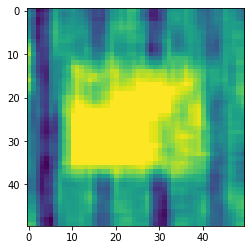

In [85]:
dis = (texture['energy'] - texture['dissimilarity'] + texture['homogeneity']).values.reshape((len(texture.i.unique()), len(texture.j.unique())))
plt.imshow(dis)

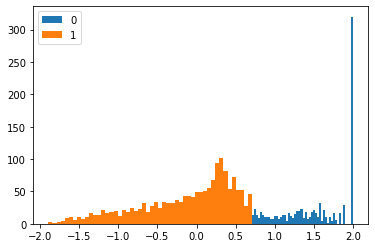

In [86]:
data = dis.flatten()
km = cluster.KMeans(2)
cluster_id = km.fit_predict(data.reshape(-1, 1))

max_bin = None
for ii in np.unique(cluster_id):
    subset = data[cluster_id == ii]
    hist, bins, _ = plt.hist(subset, bins=50, label=ii)
    if max_bin == None or bins.max() > max_bin:
        max_bin = np.min(subset)
plt.legend()
plt.show()

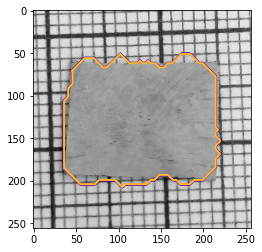

In [87]:
seg = ndimage.binary_dilation(ndimage.binary_opening(sk.transform.resize(dis > max_bin, (256, 256)), iterations=10), iterations=5)
plt.imshow(img, cmap='gray')
plt.contour(seg, cmap='plasma')